In [1]:
import datetime
import os
import requests
import pandas as pd
import numpy as np

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# to use altair for plots
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir='mydata')

DataTransformerRegistry.enable('json_dir')

In [4]:
# source of the data: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
#path = 'COVID-19-geographic-disbtribution-worldwide-2020-03-21.xlsx'

# to update the data
def get_latest_data():
    url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{}.xlsx"
    today = datetime.datetime.today()
    for day in range(1):
        date = today + datetime.timedelta(days=-day)
        url = url.format(datetime.datetime.strftime(date, '%Y-%m-%d'))
        response = requests.get(url, allow_redirects=True)
        if response.status_code == 200:
            return pd.read_excel(url)
        else:
            print(f"Data not available for date {date}")

In [5]:
# read the data
#df = pd.read_excel(path, dtype=str)
df = get_latest_data()

# defines a date column
df['date'] = pd.to_datetime(df['DateRep'], format='%Y-%m-%d')

# remove useless columns
df.drop(columns=['Day','Month','Year','GeoId','DateRep'], inplace=True)

# convert deaths and cases
for col in ['Cases', 'Deaths']:
    df[col] = df[col].astype(np.int)

# rename columns
df.rename(columns={
    'Cases':'cases',
    'Deaths':'deaths',
    'Countries and territories':'country',
}, inplace=True)

# sort the dataframe
df.sort_values(by=['country','date'], ascending=True, inplace=True)

# compute cumulative cases and cumulative_deaths
df['cumul_deaths'] = df.groupby(['country'])['deaths'].cumsum()
df['cumul_cases']  = df.groupby(['country'])['cases'].cumsum()

# keep limited number of countries
df_100_deaths = df.loc[ (df['cumul_deaths'] >= 80) , : ].copy(deep=True)
list_countries = df_100_deaths['country'].unique().tolist()
df = df.loc[ df['country'].isin(list_countries) , : ]

# compute the date of the 10th death
df_date_10_deaths = df.loc[ (df['cumul_deaths'] >= 10) , : ].sort_values(by='date').drop_duplicates(subset='country', keep='first')
df_date_10_deaths = df_date_10_deaths[['country','date']].sort_values(
    by='date', ascending=True
).rename(
    columns={'date':'date_10_deaths'}
)

# add this information to the main dataframe
df = df.merge(right=df_date_10_deaths, left_on='country', right_on='country')
df['days_since_10_death'] = ( (df['date'] - df['date_10_deaths']).dt.days ).astype(np.int)
df = df.loc[ (df['days_since_10_death'] > 0) , : ]

# sort the dataframe
df.sort_values(by=['country','days_since_10_death'], inplace=True)

6188


In [6]:
print(list_countries)
print(len(list_countries))
#
display(df.head(10))

['China', 'France', 'Iran', 'Italy', 'Netherlands', 'South_Korea', 'Spain', 'United_Kingdom', 'United_States_of_America']
9


,cases,deaths,country,date,cumul_deaths,cumul_cases,date_10_deaths,days_since_10_death
23,97,0,China,2020-01-23,17,623,2020-01-22,1
24,259,9,China,2020-01-24,26,882,2020-01-22,2
25,441,15,China,2020-01-25,41,1323,2020-01-22,3
26,665,15,China,2020-01-26,56,1988,2020-01-22,4
27,787,25,China,2020-01-27,81,2775,2020-01-22,5
28,1753,25,China,2020-01-28,106,4528,2020-01-22,6
29,1466,26,China,2020-01-29,132,5994,2020-01-22,7
30,1740,38,China,2020-01-30,170,7734,2020-01-22,8
31,1980,43,China,2020-01-31,213,9714,2020-01-22,9
32,2095,46,China,2020-02-01,259,11809,2020-01-22,10


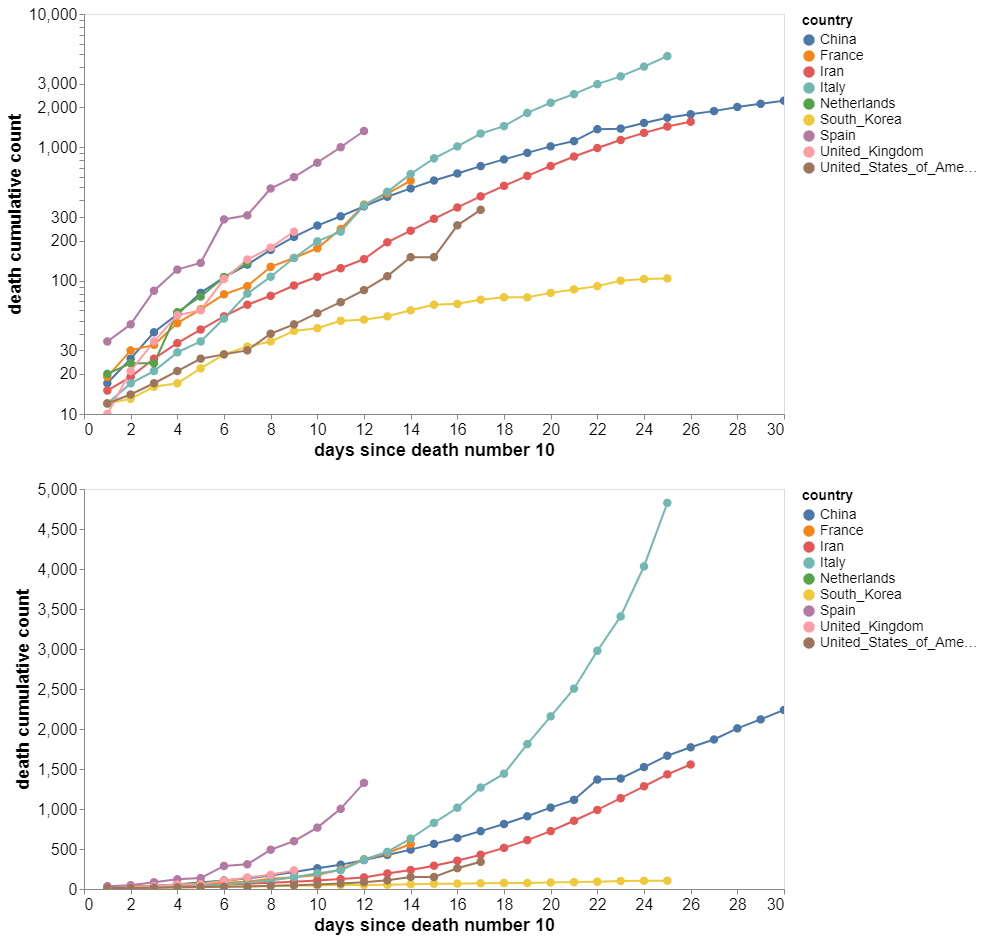

In [7]:
line_deaths_cumul = alt.Chart(df).mark_line(point=True, clip=True).encode(
        x=alt.X(
            "days_since_10_death:Q",
            axis=alt.Axis(
                title="days since death number 10",  # Title of the x-axis.
                grid=False,  # Show the x-axis grid.
            ),
            scale = alt.Scale(domain=(0,30)),
        ),
        y=alt.Y(
            "cumul_deaths:Q",
            scale = alt.Scale(type='log'),
            axis = alt.Axis(
                title  = "death cumulative count",
                grid   = False,
                offset = 0,
            ),
        ),
        color = alt.Color(
            "country:N",
            legend=alt.Legend(orient='right'),
        ),
        tooltip = [
            alt.Tooltip("country"),
            alt.Tooltip("date"),
            alt.Tooltip("days_since_10_death"),
            alt.Tooltip("date_10_deaths"),
            alt.Tooltip("deaths"),
            alt.Tooltip("cumul_deaths"),
            alt.Tooltip("cases"),
            alt.Tooltip("cumul_cases"),
        ]
    )

line_deaths_cumul_lin = alt.Chart(df).mark_line(point=True, clip=True).encode(
        x=alt.X(
            "days_since_10_death:Q",
            axis=alt.Axis(
                title="days since death number 10",  # Title of the x-axis.
                grid=False,  # Show the x-axis grid.
                #labelFontSize=18,
            ),
            scale = alt.Scale(domain=(0,30)),          
        ),
        y=alt.Y(
            "cumul_deaths:Q",
            axis = alt.Axis(
                title  = "death cumulative count",
                grid   = False,
                offset = 0,
            ),
        ),
        color = alt.Color(
            "country:N",
            legend=alt.Legend(orient='right'),
        ),
        tooltip = [
            alt.Tooltip("country"),
            alt.Tooltip("date"),
            alt.Tooltip("days_since_10_death"),
            alt.Tooltip("date_10_deaths"),
            alt.Tooltip("deaths"),
            alt.Tooltip("cumul_deaths"),
            alt.Tooltip("cases"),
            alt.Tooltip("cumul_cases"),
        ]
    )

# upper chart (logarthicmic y scale)
chart_upper = alt.layer(
    line_deaths_cumul
).properties(
    height=400,
    width=700,
)

# lower chart
chart_lower = alt.layer(
    line_deaths_cumul_lin
).properties(
    height=400,
    width=700,
)


# concat the two plots vertically
chart = alt.vconcat(
    chart_upper,
    chart_lower
).resolve_scale(
    color='independent'
).configure_axis(
    labelFontSize=16,
    titleFontSize=18
).configure_point(
    size=70
).configure_legend(
    titleFontSize=14,
    labelFontSize=14
)

# save the plot as a html file
chart.save('charts_covid_19.html')

# print the chart
display(chart)